### Some initializations

In [1]:
import json

import numpy as np
import pandas as pd
import seaborn as sb

from matplotlib.colors import LogNorm
%matplotlib inline

from trainer import hparm, path_prefix, simulation_hyperparameter_reference

In [2]:
sb.set(rc={'figure.figsize':(20,15)}, style="darkgrid")

### Simulations were run with the following hyperparameters:

In [3]:
pd.DataFrame([{"id": id, **parms._asdict()} for (id, parms) in simulation_hyperparameter_reference.items()])

,algorithm,batch_size,gamma,hidden_layer_size,id,lr,memory_size,tau,times,update_rate
0,ddqn,64,0.99,36,1,0.000500,100000,0.001,10,4
1,ddqn,64,0.99,36,2,0.005000,100000,0.001,10,4
2,ddqn,64,0.99,36,3,0.050000,100000,0.001,10,4
3,ddqn,64,0.99,36,4,0.000500,100000,0.001,10,8
4,ddqn,64,0.99,36,5,0.000500,100000,0.001,10,16
5,ddqn,64,0.99,36,6,0.000500,100000,0.010,10,4
6,ddqn,64,0.99,36,7,0.000500,100000,0.050,10,4
7,ddqn,64,0.99,36,8,0.000050,100000,0.001,10,4
8,ddqn,64,0.99,36,9,0.000500,10000,0.001,10,4
9,ddqn,64,0.99,36,10,0.000500,1000,0.001,10,4


Here I grouped different simulation runs into groups so it's easier to visualize and interpret. Each group represents a change of one major hyperparameter so analysis of impact of independent change becomes possible.

In [4]:
param_reference = dict([(id, {"id": id, **parms._asdict()}) for (id, parms) in simulation_hyperparameter_reference.items()])
experiments = {
    "Major learning rate change": ([param_reference[x] for x in [1,2,3,8]], "lr"),
    "Update rate": ([param_reference[x] for x in [1,4,5]], "update_rate"),
    "Tau": ([param_reference[x] for x in [1,6,7]], "tau"),
    "Agent replay memory size": ([param_reference[x] for x in [1,9,10]], "memory_size"),
    "Learning batch size": ([param_reference[x] for x in [1,11,12,13]], "batch_size")
#    "normality_estimation": ([param_reference[x] for x in [15, 16]], "times")
}

Some more data transformation goes below so seaborn can visualize the data without too much hassle aferwards.

In [5]:
experiment_outcomes = []
for experiment in experiments:
    (experiment_hparm, var_under_test) = experiments[experiment]
    experiment_data = [[par, pd.read_json(f"{path_prefix}set{par['id']}_results.json")] for par in experiment_hparm]
    
    for exp_item in experiment_data:
        df = exp_item[1].T
        df["episode"] = df.index
        df = df.melt(id_vars = ["episode"], var_name="run_id", value_name="score")
        df["run_id"] = df["run_id"].astype(str).astype("int64")
        df[var_under_test] = exp_item[0][var_under_test]                                          
        ma_score = df.groupby('run_id')['score'].rolling(window = 100).mean().reset_index().fillna(0)
        ma_score.columns = ["run_id", "episode", "ma_score"]
        exp_item[1] = pd.merge(df, ma_score, how="inner", left_on=["run_id", "episode"], right_on=["run_id", "episode"])

    experiment_df = pd.concat([x[1] for x in experiment_data])
    experiment_outcomes.append((experiment, experiment_df, var_under_test))

In [6]:
def render_experiment_results(results):
    plt = sb.lineplot(
        data = results[1], 
        x = 'episode', 
        y = 'ma_score', 
        hue = results[2], 
        legend = "full", 
        hue_norm = LogNorm(), 
        palette = "Paired"
    )
    plt.set_title(results[0])


Here comes the first comparison of agents with different learning rates. The learning rate change was huge so I wanted to see if there's some major semi-linear dependency between the performance and learning rate.

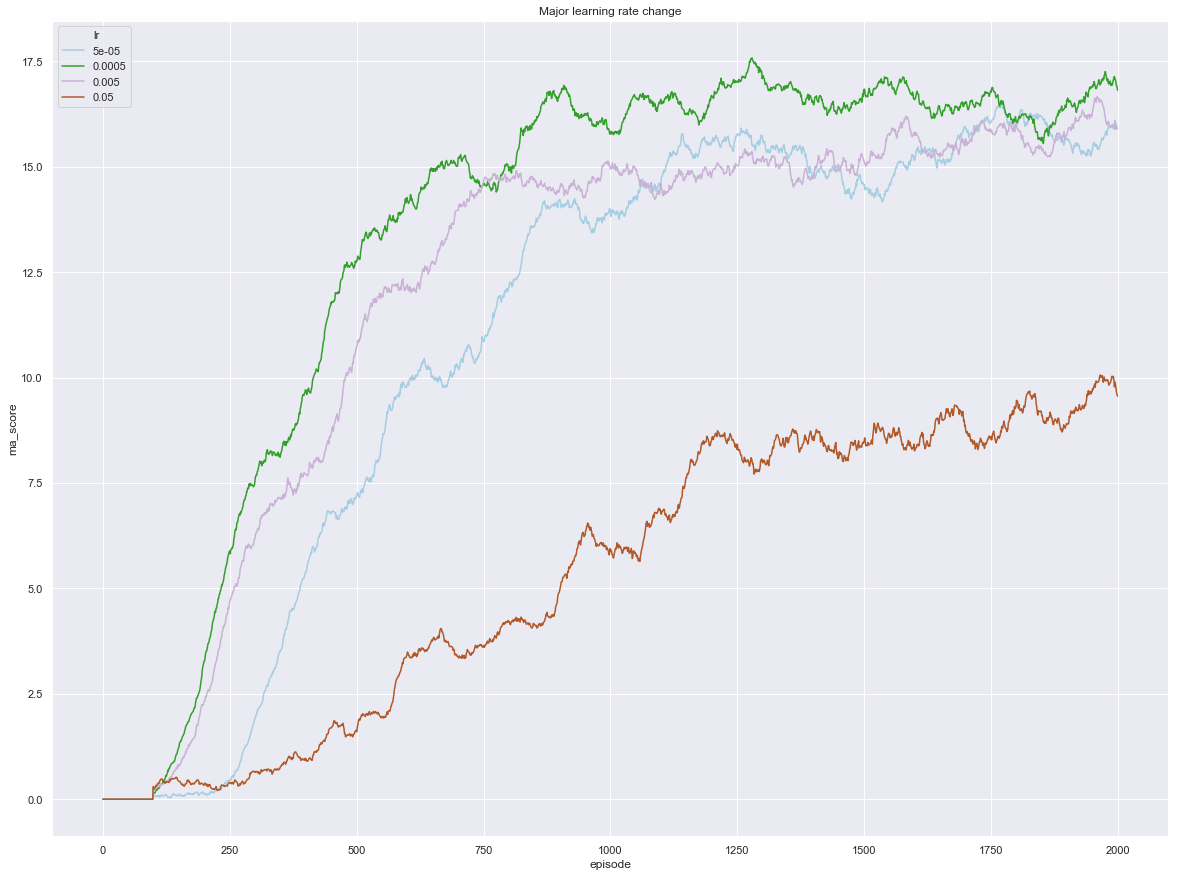

In [7]:
render_experiment_results(experiment_outcomes[0])

As it came out both extremes reduce performance, learning rate of 0.05 makes learning process incredibly slow. Making learning rate very small (5*10^5) slows initial learning process a bit, but after 800 steps it manages to catch up and at some points even outperforms larger learning rate. Suprisingly for me extremely small learning rate doesn't really improve the variance of the performance, later I will check if it happens due to a low number of samples per hyperparameter set or there are other reasons (like randomness of the environment for example) 

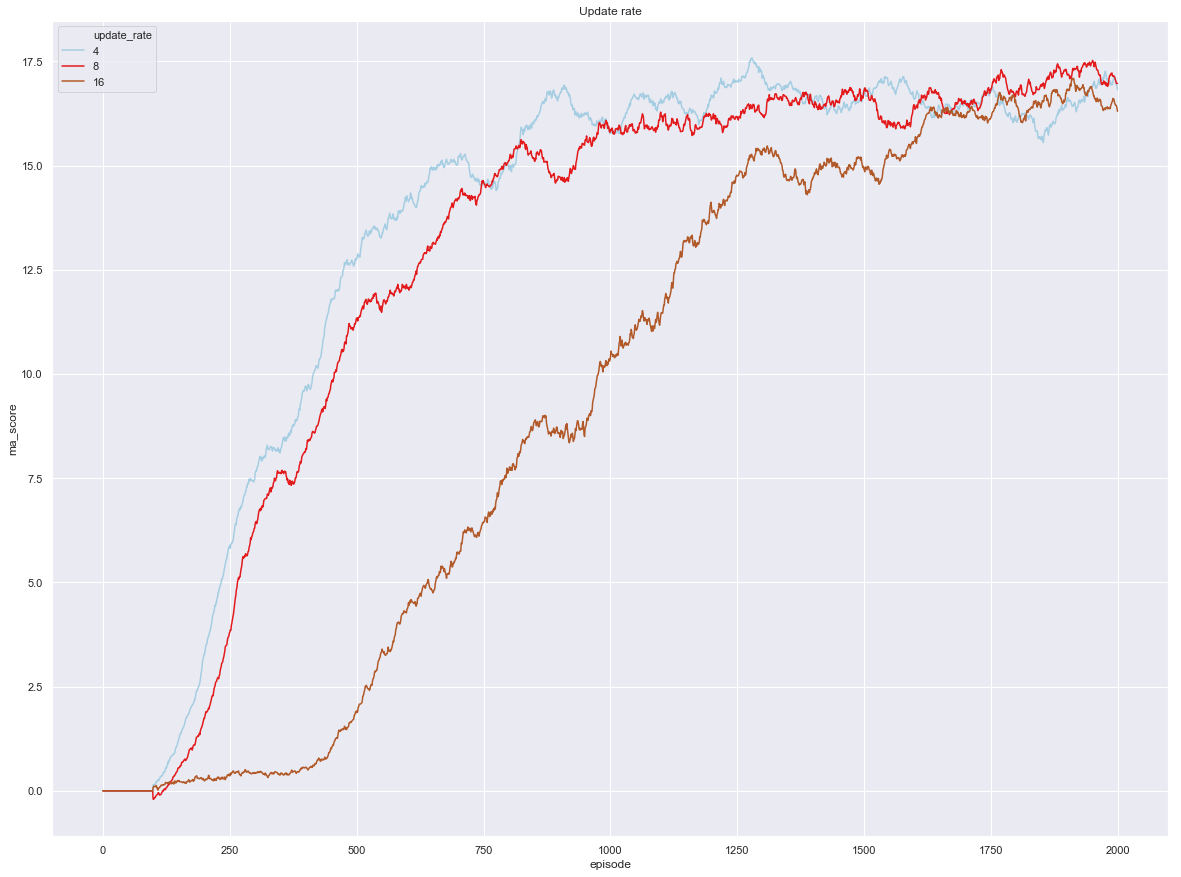

In [8]:
render_experiment_results(experiment_outcomes[1])

From this chart it becomes clear that increasing the update rate is bad for the learning process performance. I'm curious to see if that holds for DQN as well. Also values of 1 and 2 are worth trying.

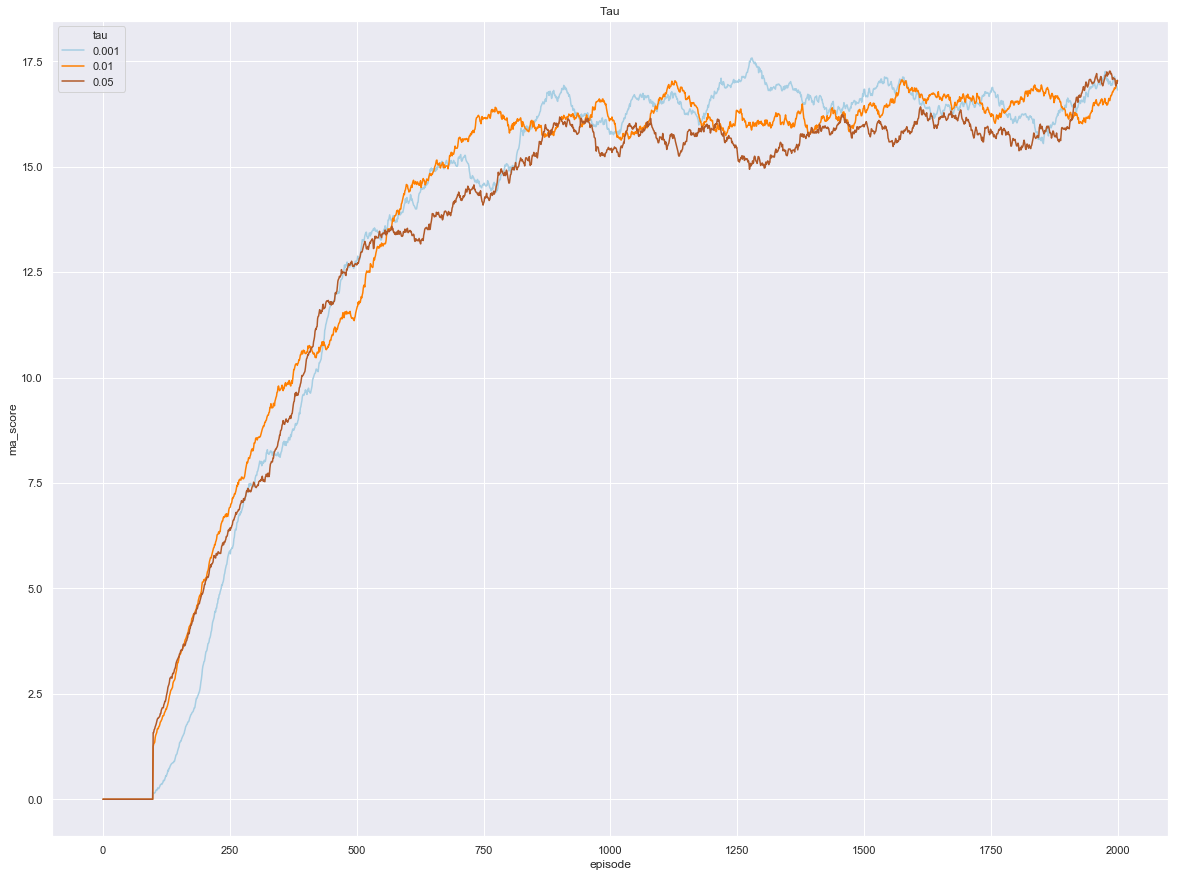

In [9]:
render_experiment_results(experiment_outcomes[2])

Tau is a coefficient of the network swap procedure. 0 means that networks are swapped, 1 means that networks stay intact. All the intermediate values define how much one network is updated by another. From the chart it is clear that small changes of tau doesn't bring any difference outside of natural learning process noise.

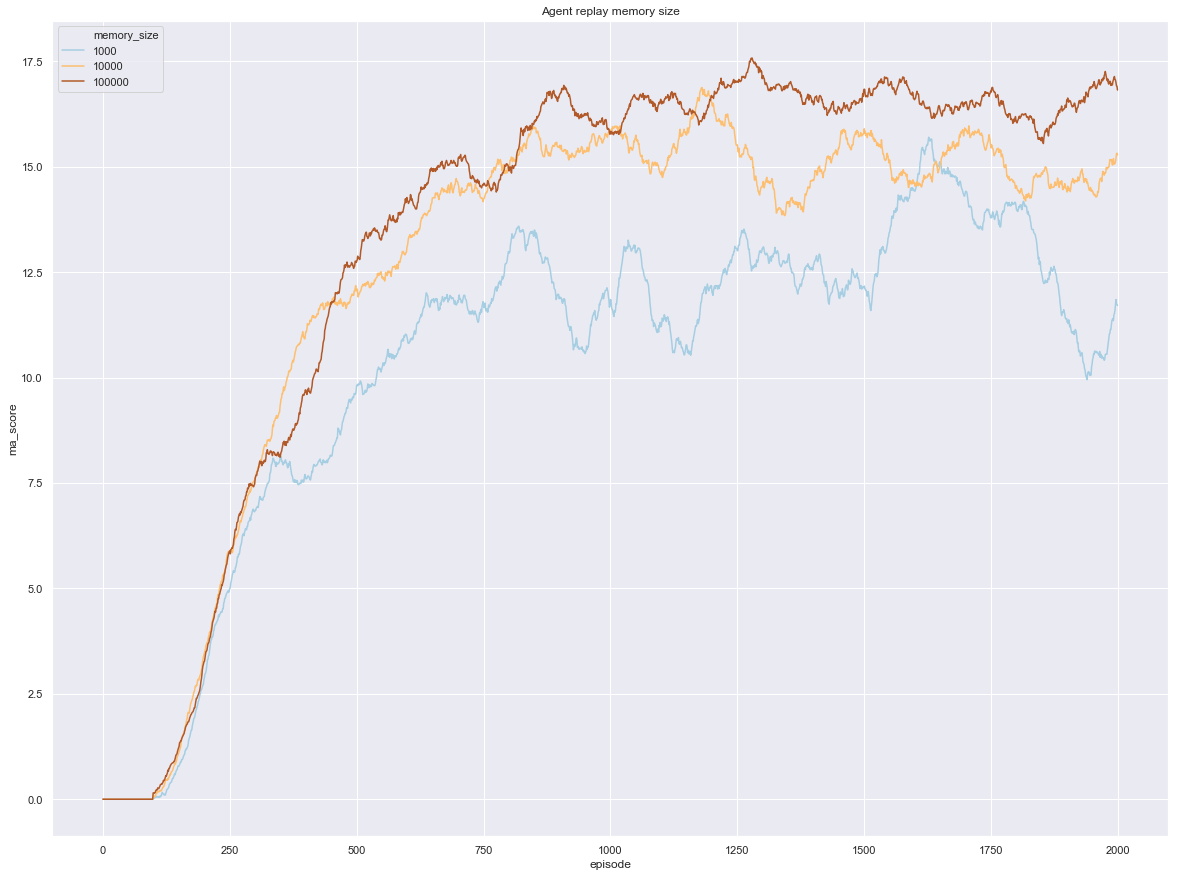

In [10]:
render_experiment_results(experiment_outcomes[3])

Memory size defines how much of past experiences are stored in order to be sampled during the next learning phase. Small memory sizes might reduce performance, still the amount of noise is too high to clearly identify the benefits of high vs medium memory sizes (100k vs 10k). 

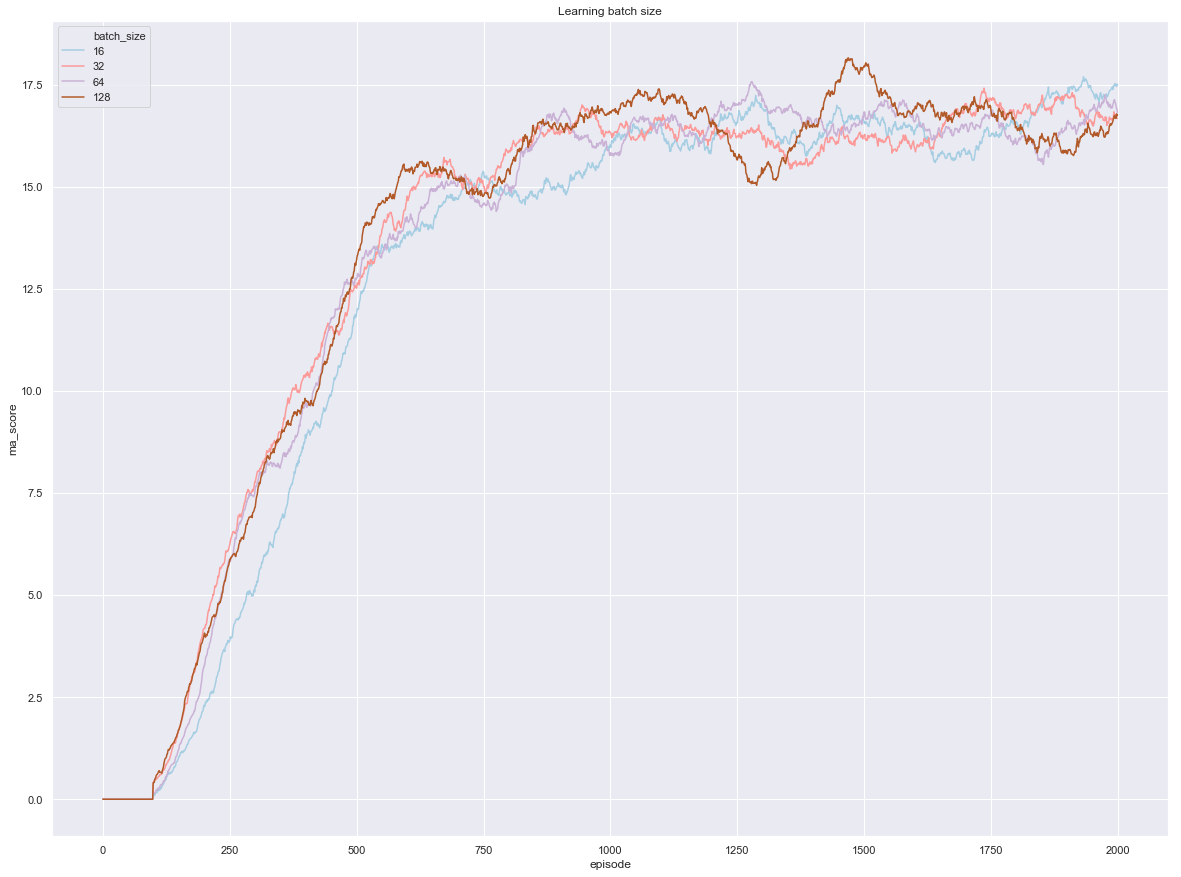

In [11]:
render_experiment_results(experiment_outcomes[4])

Learning batch doesn't give much. Rhymes, eh?